<a href="https://colab.research.google.com/github/hadi-ansari/TFX/blob/main/TFX/5)_Cat_vs_Dog_classification_(Evaluator).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TFX Pipeline Tutorial using cats & dogs dataset

In this notebook-based tutorial, we will create and run a TFX pipeline for a cats vs dogs classification model. The pipeline will consist the following components:

* ExampleGen
* StatisticsGen
* SchemaGen / Importer
* ExampleValidator
* Transform
* Trainer
* Evaluator
* Pusher


Please see
[Understanding TFX Pipelines](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines)
to learn more about various concepts in TFX.

## Set Up
We first need to install the TFX Python package and download
the dataset which we will use for our model.


### Upgrade Pip

In [ ]:
!pip install --upgrade pip

### Install TFX

In [ ]:
!pip install -U tfx

### Uninstall shapely

TODO(b/263441833) This is a temporal solution to avoid an
ImportError. Ultimately, it should be handled by supporting a
recent version of Bigquery, instead of uninstalling other extra
dependencies.

In [ ]:
!pip uninstall shapely -y

### Did you restart the runtime?

If you are using Google Colab, the first time that you run
the cell above, you must restart the runtime by clicking
above "RESTART RUNTIME" button or using "Runtime > Restart
runtime ..." menu. This is because of the way that Colab
loads packages.

## Necessary imports

We also check the TensorFlow and TFX versions.

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import tensorflow as tf
from absl import logging

# Uncomment this for seeing the logs while running the pipeline
#logging.set_verbosity(logging.INFO)  # Set default logging level.

print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.11.1
TFX version: 1.12.0


## Load you Kaggle API key

In [ ]:
from google.colab import files
files.upload()

## Download the cat vs dog dataset
Because TFX ExampleGen reads inputs from a directory, we need to create a
directory and copy dataset to it.

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json'
!kaggle datasets download -d salader/dogs-vs-cats
!unzip dogs-vs-cats.zip
!rm -rf test train dogs-vs-cats.zip

## Reduce size of the dataset (optional)
We reduce size of the dataset by removing the images from both train and test folders to speed up the ML process. Train images decreas from 20000 images to 2000 and test images decreas from 5000 to 500 images.

In [ ]:
!ls -1 dogs_vs_cats/train/dogs/* | tail -n +1001 | xargs rm 
!ls -1 dogs_vs_cats/train/cats/* | tail -n +1001 | xargs rm

!ls -1 dogs_vs_cats/test/dogs/* | tail -n +251 | xargs rm 
!ls -1 dogs_vs_cats/test/cats/* | tail -n +251 | xargs rm 

## Set up variables

There are some variables used to define a pipeline. You can customize these
variables as you want. By default all output from the pipeline will be
generated under the current directory.

In [8]:
_trainer_module_file = 'dogs_vs_cats_trainer.py'
schema_path = 'schema' # create this directory and copy your generated schema here in order to use the Importer.

data_root ='dogs_vs_cats'
train_dir = os.path.join(data_root, 'train')
validation_dir = os.path.join(data_root, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 128
PIPELINE_NAME = 'dogs_vs_cats_pipeline'
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'cat&dog_md.db')


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 250
total validation dog images: 250
--
Total training images: 2000
Total validation images: 500


## Convert image dataset to TFRecords

We followed the instructions according [this](https://ai.plainenglish.io/a-quick-and-simple-guide-to-tfrecord-c421337a6562).


In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import random
import cv2
import matplotlib.pyplot as plt
from io import BytesIO

# Setup the train and test imgage directories
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")

# setup train and test TFRecord file
train_tfrecord='train_data.tfrecords'
test_tfrecord = 'test_data.tfrecords'

# Define the name of folders of each class
# We only have two classes in this case.
folders=['dogs', 'cats']

# List all train and test image path
train_image_path=[]
test_image_path=[]

for i in range(len(folders)):
    for file in os.listdir(os.path.join(train_dir, folders[i])):
        train_image_path.append(os.path.join(train_dir, folders[i], file))
    for file in os.listdir(os.path.join(test_dir, folders[i])):
        test_image_path.append( os.path.join(test_dir, folders[i], file))


print("Number of train images found: ", len(train_image_path))
print("Number of test images found: ", len(test_image_path))

# Shuffle the image paths for better accuracy and precision
random.seed(0)
random.shuffle(train_image_path)
random.shuffle(test_image_path)

# create train and test lables for shuffled image paths
# 0 for cat and 1 for dog
train_labels=[]
test_labels=[]
for i in range(len(train_image_path)):
    if os.path.basename(train_image_path[i])[:3]=='cat':
        train_labels.append(0)
    else:
        train_labels.append(1)

for i in range(len(test_image_path)):
    if os.path.basename(test_image_path[i])[:3]=='cat':
        test_labels.append(0)
    else:
        test_labels.append(1)

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""    
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def serialize_example(image_string, label):
    ## Create a dictionary with features for images and their target labels
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
    }
    #  Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    #serializes the message and returns it as a string. Note that the bytes are binary
    return example_proto.SerializeToString()

def write_TFRecord(image_path, label):
    # Load the image and resize it
    image = Image.open(image_path)
    image = image.resize([IMG_HEIGHT, IMG_WIDTH])

    # Convert the resized image to bytes
    with BytesIO() as output:
        image.save(output, format='JPEG')
        image_bytes = output.getvalue()

    # Serialize the example
    example = serialize_example(image_bytes, label)
    return example


#Write Train TFRecord file
with tf.io.TFRecordWriter(train_tfrecord) as writer:
    for image_path, label in zip(train_image_path, train_labels):
        writer.write(write_TFRecord(image_path, int(label)))
#Write Test TFRecord file
with tf.io.TFRecordWriter(test_tfrecord) as writer:
    for image_path, label in zip(test_image_path, test_labels):
         writer.write(write_TFRecord(image_path, int(label)))

Number of train images found:  2000
Number of test images found:  500


## Anomaly test
This code is to test anomaly and ExampleValidator component. Do **not** run this code if you do not want to add a invalid data into the dataset.

In [ ]:
with tf.io.TFRecordWriter(train_tfrecord) as writer:
    for image_path, label in zip(train_image_path, train_labels):
      writer.write(write_TFRecord(image_path, 3))
      break

## Restructure the files
This commands restructure the files and create a directory named `dataset` and move the TFRecord files into `dataset/train` and `dataset/test`.

In [ ]:
!rm -rf dataset
!mkdir dataset
!mkdir dataset/train
!mkdir dataset/test
!mv train_data.tfrecords dataset/train
!mv test_data.tfrecords dataset/test

## Write Trainer and Transform code

We will create a simple CNN (Convolutional Neural Network) model for cats vs dogs classification using TensorFlow Keras
API. This model training code will be saved to a separate file.

For model training code we found this tutorial on Kaggle
[here](https://www.kaggle.com/code/alpaca0984/dogs-vs-cats-tensorflow-2-0-on-google-colab). You need to write a Python file
containing `run_fn` function, which is the entrypoint for the `Trainer`
component. For the `Transform` component you need to have a function called `preprocessing_fn(inputs)`.

In [5]:
%%writefile {_trainer_module_file}


import tensorflow as tf
from tfx import v1 as tfx
import matplotlib.pyplot as plt
import tensorflow_transform as tft
from tfx_bsl.tfxio import dataset_options
import os
import gzip
from typing import List
from tensorflow_metadata.proto.v0 import schema_pb2
from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_transform.tf_metadata import schema_utils

_IMAGE_KEY = 'image_raw'
_LABEL_KEY = 'label'
IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 128

_TRAIN_DATA_SIZE = 1000
_TEST_DATA_SIZE = 300


def _transformed_name(key):
  return key + '_xf'

# TFX Transform will call this function.
def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.
  Args:
    inputs: map from feature keys to raw not-yet-transformed features.
  Returns:
    Map from string feature key to transformed feature operations.
  """
  outputs = {}

  image_features = tf.map_fn(
      lambda x: tf.io.decode_jpeg(x[0], channels=3),
      inputs[_IMAGE_KEY],
      dtype=tf.uint8)
  
  image_features = tf.image.resize(image_features, [IMG_HEIGHT, IMG_WIDTH])
  # Normalize the image features
  # image_features = image_features / 255.0

  image_features = tf.keras.applications.mobilenet.preprocess_input(image_features)

  outputs[_transformed_name(_IMAGE_KEY)] = image_features
  outputs[_transformed_name(_LABEL_KEY)] = inputs[_LABEL_KEY]
  
  return outputs


# Define a function to parse the tfrecord dataset
def _parse_function(features, label):
   image = features[_transformed_name(_IMAGE_KEY)]
   return image, label

def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              tf_transform_output: tft.TFTransformOutput,
              batch_size: int = 128) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """  
  dataset = data_accessor.tf_dataset_factory(
      file_pattern,
      dataset_options.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_transformed_name(_LABEL_KEY)),
      tf_transform_output.transformed_metadata.schema).repeat()
  
  return dataset


def _get_serve_image_fn(model):
  """Returns a function that feeds the input tensor into the model."""

  @tf.function
  def serve_image_fn(image_tensor):
    """Returns the output to be used in the serving signature.
    Args:
      image_tensor: A tensor represeting input image. The image should have 3
        channels.
    Returns:
      The model's predicton on input image tensor
    """
    return model(image_tensor)

  return serve_image_fn


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
    
    print("\n\n\n Trainer component is running ... \n\n\n")

    epochs = 3
    # Create the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), name=_transformed_name(_IMAGE_KEY)),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
 
    # Print a summary of the model
    model.summary()

    tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)
 
    train_ds = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      tf_transform_output,
      batch_size=batch_size)

    train_ds = train_ds.map(_parse_function)

    eval_ds = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      tf_transform_output,
      batch_size=batch_size)
    
    eval_ds = eval_ds.map(_parse_function)

    steps_per_epoch = int(_TRAIN_DATA_SIZE / batch_size)
    validation_steps = int(_TEST_DATA_SIZE / batch_size)

    # Train our model
    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=eval_ds, 
                        steps_per_epoch=steps_per_epoch, 
                        validation_steps=validation_steps)


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


    # Prepare the TFLite model used for serving in MLKit
    signatures = {
        'serving_default':
            _get_serve_image_fn(model).get_concrete_function(
                tf.TensorSpec(
                    shape=[None, IMG_HEIGHT, IMG_WIDTH, 3],
                    dtype=tf.float32,
                    name=_transformed_name(_IMAGE_KEY)))
    }


    # The result of the training should be saved in `fn_args.serving_model_dir`
    # directory.
    model.save(fn_args.serving_model_dir, save_format='tf')

Writing {_trainer_module_file}


## Define the pipeline
We define the ML pipeline here. The components of the pipeline are: * ExampleGen
* StatisticsGen
* SchemaGen / Importer
* ExampleValidator
* Transform
* Trainer
* Evaluator
* Pusher

Run one of the following alternatives depending on if you have generated schema or not. Normally you need to run the **ALTERNATIVE 1** only for the first time.

For ingesting the image dataset into the pipeline, we got help from this github repository [github](https://github.com/tensorflow/tfx/blob/master/tfx/examples/cifar10/cifar10_pipeline_native_keras.py)

### Alternative 1 (SchemaGen)
In case you do have **NOT** generated schema, opt for this method.

In [6]:
from tfx.proto import example_gen_pb2
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.dsl.components.common import resolver
import tensorflow_model_analysis as tfma
from tfx.types import Channel
from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy

def _create_pipeline(pipeline_name: str, pipeline_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str, accuracy_threshold: float = 0.55) -> tfx.dsl.Pipeline:
  print("Pipeline creation is running...\n\n\n")

  """Creates a three component penguin pipeline with TFX."""
 
  input_config = example_gen_pb2.Input(splits=[
      example_gen_pb2.Input.Split(name='train', pattern='train/*'),
      example_gen_pb2.Input.Split(name='eval', pattern='test/*')
  ])

  # Brings data into the pipeline.
  example_gen = tfx.components.ImportExampleGen(
      input_base='/content/dataset', input_config=input_config)

  # Computes statistics over data for visualization and schema generation.
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])
  
  # Generates schema based on the generated statistics.
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
  
  #Performs anomaly detection based on statistics and data schema.
  example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema = schema_gen.outputs['schema']
  )

  # Performs transformations and feature engineering in training and serving.
  transform = tfx.components.Transform(
      examples=example_gen.outputs['examples'],
      schema=schema_gen.outputs['schema'],
      module_file=module_file)
  
  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=transform.outputs['transformed_examples'],
      transform_graph=transform.outputs['transform_graph'],
      schema= schema_gen.outputs['schema']
      )
  
 # Get the latest blessed model for model validation.
  model_resolver = resolver.Resolver(
      strategy_class=LatestBlessedModelStrategy,
      model=Channel(type=Model),
      model_blessing=Channel(
          type=ModelBlessing)).with_id('latest_blessed_model_resolver')


  # Uses TFMA to compute evaluation statistics over features of a model and
  # perform quality validation of a candidate model (compare to a baseline).
  eval_config = tfma.EvalConfig(
      model_specs=[tfma.ModelSpec(label_key='label_xf')],
      slicing_specs=[tfma.SlicingSpec()],
      metrics_specs=[
          tfma.MetricsSpec(metrics=[
              tfma.MetricConfig(
                  class_name='SparseCategoricalAccuracy',
                  threshold=tfma.MetricThreshold(
                      value_threshold=tfma.GenericValueThreshold(
                          lower_bound={'value': 0.5}),
                      # Change threshold will be ignored if there is no
                      # baseline model resolved from MLMD (first run).
                      change_threshold=tfma.GenericChangeThreshold(
                          direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                          absolute={'value': -1e-3})))
          ])
      ])

  # Uses TFMA to compute the evaluation statistics over features of a model.
  # We evaluate using the materialized examples that are output by Transform
  # because
  # 1. the decoding_png function currently performed within Transform are not
  # compatible with TFLite.
  # 2. MLKit requires deserialized (float32) tensor image inputs
  # Note that for deployment, the same logic that is performed within Transform
  # must be reproduced client-side.
  evaluator = tfx.components.Evaluator(
      examples=transform.outputs['transformed_examples'],
      model=trainer.outputs['model'],
      baseline_model=model_resolver.outputs['model'],
      eval_config=eval_config)
  
  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      model_blessing=evaluator.outputs['blessing'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))
  
  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      example_validator,
      transform,
      trainer,
      model_resolver, 
      evaluator,
      pusher
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

### Alternative 2 (Importer)
In case you do have generated schema, opt for this method. After running the pipeline with SchemaGen (**ALTERNATIVE 1)** a schema is created in `pipelines/SchemaGen/schema/[number]/` direcotry. For the second time and for avoiding schema generation every time this schema can be imported using Importer component. You need to also create a directory named `schema` and copy the generated schema into it.

In [ ]:
from tfx.proto import example_gen_pb2
from tfx.types.standard_artifacts import Model
from tfx.types.standard_artifacts import ModelBlessing
from tfx.dsl.components.common import resolver
import tensorflow_model_analysis as tfma
from tfx.types import Channel

from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy
from tfx.types.standard_artifacts import Model, ModelBlessing

def _create_pipeline(pipeline_name: str, pipeline_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str, accuracy_threshold: float = 0.55) -> tfx.dsl.Pipeline:
  print("Pipeline creation is running...\n\n\n")

  """Creates a three component penguin pipeline with TFX."""
 
  input_config = example_gen_pb2.Input(splits=[
      example_gen_pb2.Input.Split(name='train', pattern='train/*'),
      example_gen_pb2.Input.Split(name='eval', pattern='test/*')
  ])
  # Brings data into the pipeline.
  example_gen = tfx.components.ImportExampleGen(
      input_base='/content/dataset', input_config=input_config)

  # Computes statistics over data for visualization and schema generation.
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])
  
  # Import the schema.
  schema_importer = tfx.dsl.Importer(
      source_uri = schema_path,
      artifact_type = tfx.types.standard_artifacts.Schema).with_id(
          'schema_importer')

  # Performs anomaly detection based on statistics and data schema.
  example_validator = tfx.components.ExampleValidator(
      statistics=statistics_gen.outputs['statistics'],
      schema=schema_importer.outputs['result']
  )

  # Performs transformations and feature engineering in training and serving.
  transform = tfx.components.Transform(
      examples=example_gen.outputs['examples'],
      schema=schema_importer.outputs['result'],
      module_file=module_file)
  
  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=transform.outputs['transformed_examples'],
      transform_graph=transform.outputs['transform_graph'],
      schema=schema_importer.outputs['result']
      )
  
  # Get the latest blessed model for model validation.
  model_resolver = resolver.Resolver(
      strategy_class=LatestBlessedModelStrategy,
      model=Channel(type=Model),
      model_blessing=Channel(
          type=ModelBlessing)).with_id('latest_blessed_model_resolver')


  # Uses TFMA to compute evaluation statistics over features of a model and
  # perform quality validation of a candidate model (compare to a baseline).
  eval_config = tfma.EvalConfig(
      model_specs=[tfma.ModelSpec(label_key='label_xf')],
      slicing_specs=[tfma.SlicingSpec()],
      metrics_specs=[
          tfma.MetricsSpec(metrics=[
              tfma.MetricConfig(
                  class_name='SparseCategoricalAccuracy',
                  threshold=tfma.MetricThreshold(
                      value_threshold=tfma.GenericValueThreshold(
                          lower_bound={'value': 0.5}),
                      # Change threshold will be ignored if there is no
                      # baseline model resolved from MLMD (first run).
                      change_threshold=tfma.GenericChangeThreshold(
                          direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                          absolute={'value': -1e-3})))
          ])
      ])

  # Uses TFMA to compute the evaluation statistics over features of a model.
  # We evaluate using the materialized examples that are output by Transform
  # because
  # 1. the decoding_png function currently performed within Transform are not
  # compatible with TFLite.
  # 2. MLKit requires deserialized (float32) tensor image inputs
  # Note that for deployment, the same logic that is performed within Transform
  # must be reproduced client-side.
  evaluator = tfx.components.Evaluator(
      examples=transform.outputs['transformed_examples'],
      model=trainer.outputs['model'],
      baseline_model=model_resolver.outputs['model'],
      eval_config=eval_config)
  
  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      model_blessing=evaluator.outputs['blessing'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))
  
  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      #statistics_gen,
      schema_importer,
      #example_validator,
      transform,
      trainer,
      model_resolver,
      evaluator,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

# Run the pipeline

TFX supports multiple orchestrators to run pipelines.
In this tutorial we will use `LocalDagRunner` which is included in the TFX
Python package and runs pipelines on local environment.
We often call TFX pipelines "DAGs" which stands for directed acyclic graph.

`LocalDagRunner` provides fast iterations for development and debugging.
TFX also supports other orchestrators including Kubeflow Pipelines and Apache
Airflow which are suitable for production use cases.

See
[TFX on Cloud AI Platform Pipelines](https://www.tensorflow.org/tfx/tutorials/tfx/cloud-ai-platform-pipelines)
or
[TFX Airflow Tutorial](https://www.tensorflow.org/tfx/tutorials/tfx/airflow_workshop)
to learn more about other orchestration systems.

Pipeline creation is running...





Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
Use ref() instead.





 Trainer component is running ... 



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_raw_xf (Conv2D)       (None, 150, 150, 32)      896       
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)           

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/3
7/7 [==============================] - 196s 27s/step - loss: 0.7815 - accuracy: 0.4989 - val_loss: 0.6934 - val_accuracy: 0.4883
Epoch 2/3
7/7 [==============================] - 202s 30s/step - loss: 0.6941 - accuracy: 0.4978 - val_loss: 0.6919 - val_accuracy: 0.5312
Epoch 3/3
7/7 [==============================] - 181s 26s/step - loss: 0.6916 - accuracy: 0.5223 - val_loss: 0.6933 - val_accuracy: 0.4961


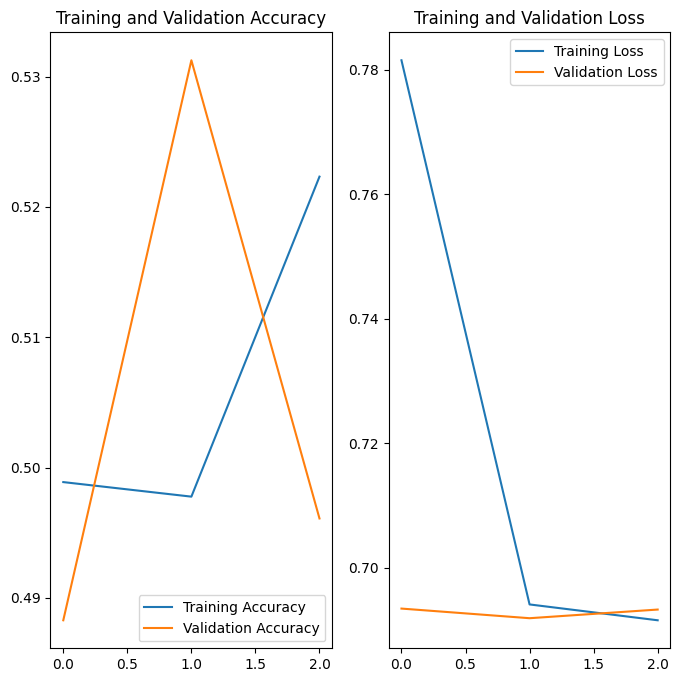

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [9]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

The pusher component pushes the trained model to the `SERVING_MODEL_DIR` which
is the `serving_model/dogs_vs_cats_pipeline` directory if you did not change the
variables in the previous steps. You can see the result from the file browser
in the left-side panel in Colab, or using the following command:

In [10]:
# List files in created model directory.
!find {SERVING_MODEL_DIR}

serving_model/dogs_vs_cats_pipeline
serving_model/dogs_vs_cats_pipeline/1682344135
serving_model/dogs_vs_cats_pipeline/1682344135/keras_metadata.pb
serving_model/dogs_vs_cats_pipeline/1682344135/variables
serving_model/dogs_vs_cats_pipeline/1682344135/variables/variables.index
serving_model/dogs_vs_cats_pipeline/1682344135/variables/variables.data-00000-of-00001
serving_model/dogs_vs_cats_pipeline/1682344135/saved_model.pb
serving_model/dogs_vs_cats_pipeline/1682344135/assets
serving_model/dogs_vs_cats_pipeline/1682344135/fingerprint.pb


# Review outputs of the pipeline

In [11]:
from ml_metadata.proto import metadata_store_pb2
# Non-public APIs, just for showcase.
from tfx.orchestration.portable.mlmd import execution_lib

# TODO(b/171447278): Move these functions into the TFX library.

def get_latest_artifacts(metadata, pipeline_name, component_id):
  """Output artifacts of the latest run of the component."""
  context = metadata.store.get_context_by_type_and_name(
      'node', f'{pipeline_name}.{component_id}')
  executions = metadata.store.get_executions_by_context(context.id)
  latest_execution = max(executions,
                         key=lambda e:e.last_update_time_since_epoch)
  return execution_lib.get_output_artifacts(metadata, latest_execution.id)

# Non-public APIs, just for showcase.
from tfx.orchestration.experimental.interactive import visualizations

def visualize_artifacts(artifacts):
  """Visualizes artifacts using standard visualization modules."""
  for artifact in artifacts:
    visualization = visualizations.get_registry().get_visualization(
        artifact.type_name)
    if visualization:
      visualization.display(artifact)

from tfx.orchestration.experimental.interactive import standard_visualizations
standard_visualizations.register_standard_visualizations()

In [12]:
# Non-public APIs, just for showcase.
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs

metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  # Find output artifacts from MLMD.
  stat_gen_output = get_latest_artifacts(metadata_handler, PIPELINE_NAME,
                                         'StatisticsGen')
  stats_artifacts = stat_gen_output[standard_component_specs.STATISTICS_KEY]

  schema_gen_output = get_latest_artifacts(metadata_handler,
                                           PIPELINE_NAME, 'SchemaGen')
  schema_artifacts = schema_gen_output[standard_component_specs.SCHEMA_KEY]

## Visualize output of StatisticsGen

In [13]:
visualize_artifacts(stats_artifacts)

## Visualize output of SchemaGen

In [ ]:
visualize_artifacts(schema_artifacts)

,Type,Presence,Valency,Domain
Feature name,,,,
'depth',INT,required,,-
'height',INT,required,,-
'image_raw',BYTES,required,,-
'label',INT,required,,-
'width',INT,required,,-


## Visualize output of ExampleValidator

In [14]:
metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  ev_output = get_latest_artifacts(metadata_handler, PIPELINE_NAME,
                                   'ExampleValidator')
  anomalies_artifacts = ev_output[standard_component_specs.ANOMALIES_KEY]

In [15]:
visualize_artifacts(anomalies_artifacts)

# Prediction
Copy and paste path of one pushed model to load it and use it for prediction of images. The pushed models are inside `/content/serving_model/dogs_vs_cats_pipeline/[number]` directory.

In [16]:
eval_ds = tf.keras.utils.image_dataset_from_directory(
    "./dogs_vs_cats/test",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
)


model = tf.keras.models.load_model('/content/serving_model/dogs_vs_cats_pipeline/1682344135')
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])



predictions = probability_model.predict(eval_ds)

Found 500 files belonging to 2 classes.
16/16 [==============================] - 31s 2s/step


In [17]:
# Use the trained model to predict on the eval_ds dataset
predictions = model.predict(eval_ds)

# Print the predictions for the first 10 images in the dataset
for image, prediction in zip(eval_ds, predictions):
    predicted_label = "dog" if prediction > 0.5 else "cat"
    true_label = "dog" if image[1].numpy()[0] == 1 else "cat"
    print("Predicted label: ", predicted_label)
    print("True label: ", true_label)

16/16 [==============================] - 27s 2s/step
Predicted label:  dog
True label:  dog
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  dog
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  dog
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  dog
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  dog
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  cat
Predicted label:  dog
True label:  cat
